## Import Statements

In [3]:
import copy
import random
import sys
from PIL import Image

sys.path.append('../Mendota/')
import resnet

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [4]:
data = pd.read_json('../Data/data.json')

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(data[['label', 'algalBloomSheen_one_day', 'algalBloomSheen_three_day', 'algalBloomSheen_one_week']])

labels = data[['label']]
data = data.drop('label', axis='columns')

## Add Features

In [5]:
data['log_turbidity'] = np.log(data['turbidity'] + 1)

## Correlation

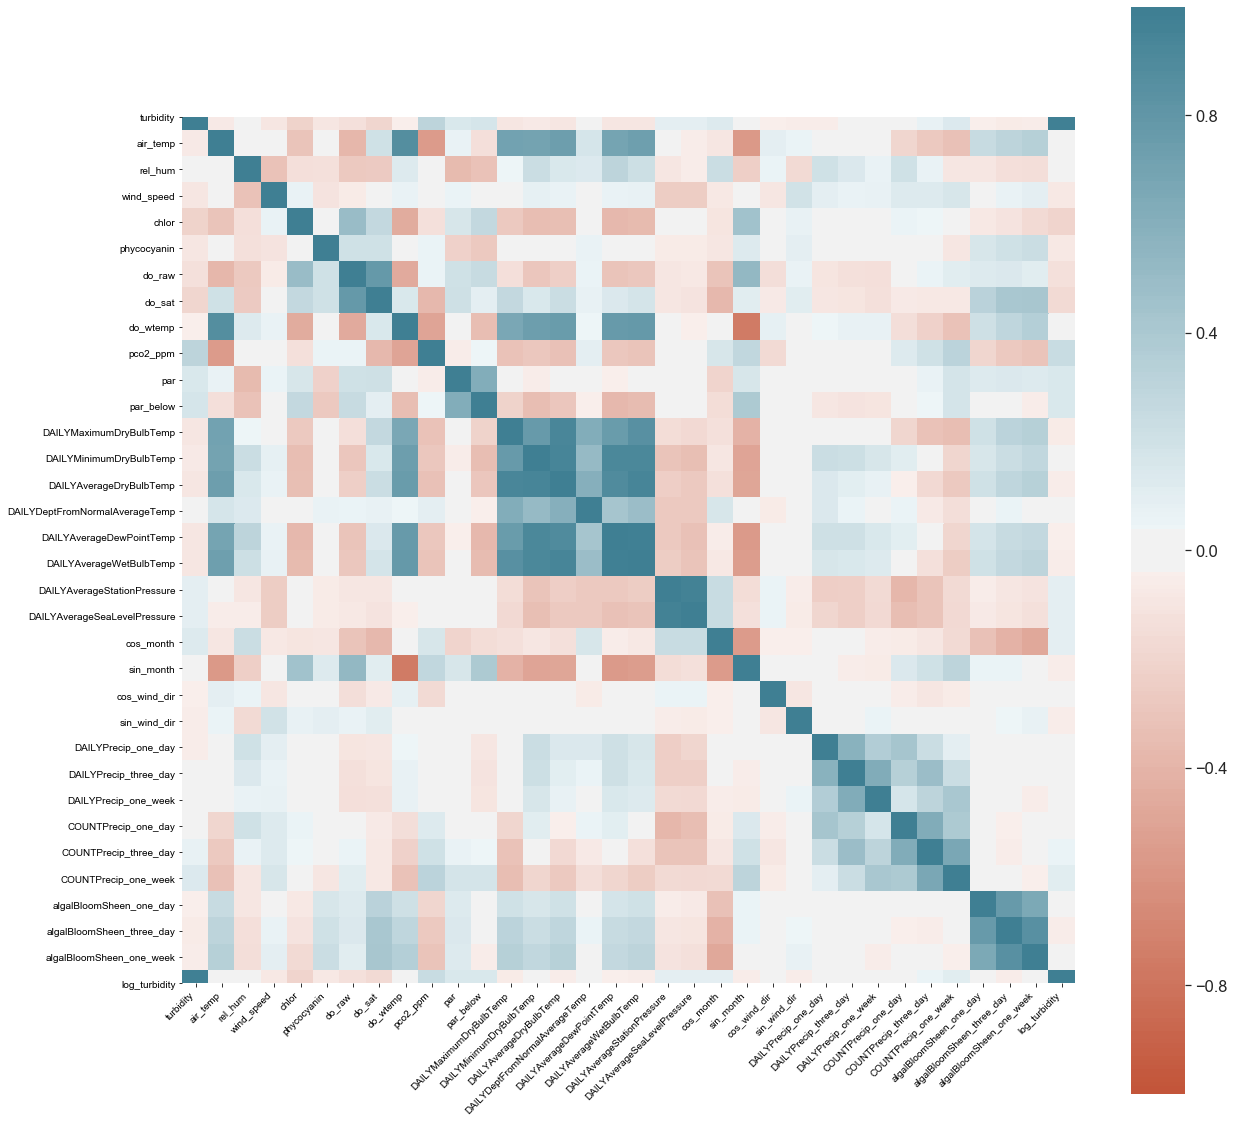

In [6]:
corr = data.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Removed features: 
	 log_turbidity
	 do_wtemp
	 DAILYAverageDryBulbTemp
	 DAILYAverageWetBulbTemp
	 DAILYAverageDewPointTemp
	 DAILYAverageSeaLevelPressure
	 algalBloomSheen_one_week


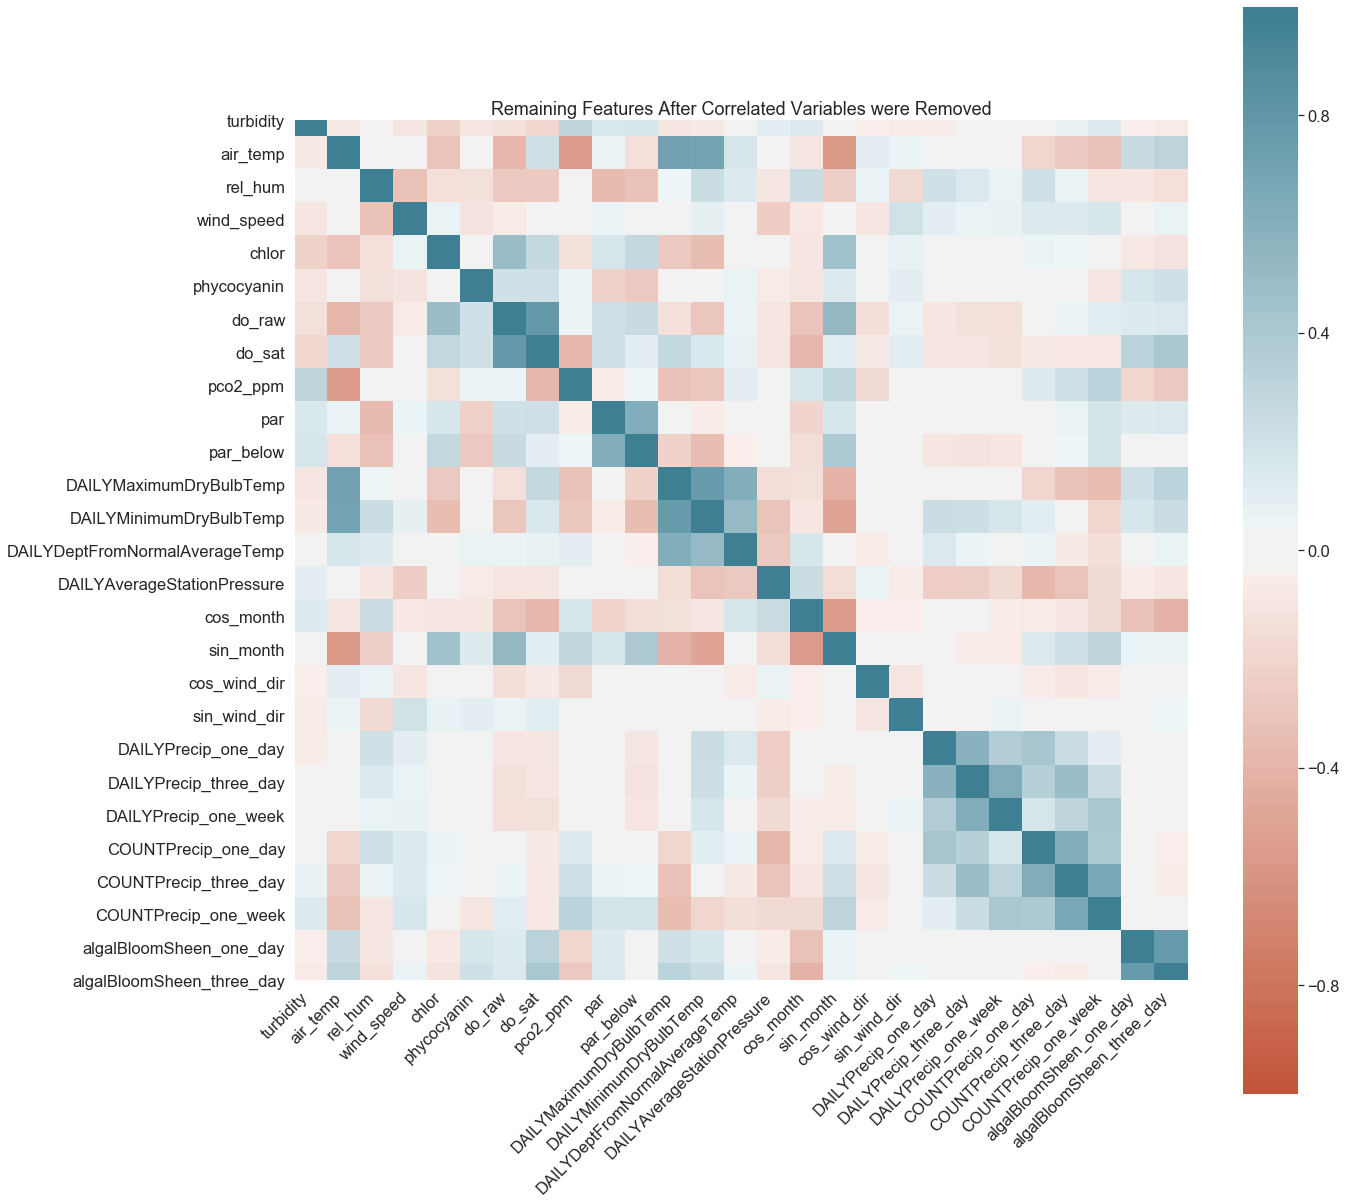

In [7]:
corr_thresh = 0.80  # threshold for correlation. for any two variables with correlation > thresh, one is removed

thresh = corr.abs() > corr_thresh

keep = copy.deepcopy(data.columns).to_list()

print('Removed features: ')
# keep features whose correlation with other features is <= corr_thresh
for i in range(0, len(thresh.index)):
    for j in range(i+1, len(thresh.columns)):
        if thresh.iloc[i, j]:
            if thresh.columns[j] in keep:
                print('\t', thresh.columns[j])
                keep.remove(thresh.columns[j])

# handpicked keep based on results above
# keep = ['turbidity', 'rel_hum', 'wind_speed', 'chlor',
#        'phycocyanin', 'do_sat', 'do_wtemp', 'pco2_ppm', 'par',
#        'par_below', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp',
#        'DAILYPrecip',
#        'DAILYAverageStationPressure',
#        'cos_month', 'sin_month', 'cos_wind_dir', 'sin_wind_dir',
#        'DAILYPrecip_one_day', 'DAILYPrecip_three_day', 'DAILYPrecip_one_week',
#        'algalBloomSheen_one_week']

df = data[keep]

df_corr = df.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    df_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Remaining Features After Correlated Variables were Removed');

## Prepare Data/Create Dataloaders

In [8]:
class AlgalBloomDataset(data_utils.Dataset):

    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array): numpy array of data samples
            labels (numpy array): numpy array of labels for the data samples
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.fromarray(self.data[idx])
        target = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, target

In [9]:
train_size = 0.7
batch_size = 16
data_aug = False    # data augmentation

# zero pad data set. The input format for the resnet must be 5x5, or 6x6, or 7x7, etc.
pad_df = copy.deepcopy(df)
for i in range(36-df.shape[1]):
    pad_df[i] = [1 for _ in range(df.shape[0])]

vals = pad_df.values
data_reshape = []
for i in range(pad_df.shape[0]):
    data_reshape.append(vals[i].reshape(6, 6))

# split into training and testing sets
num_train = int(len(data_reshape) * train_size)
idx = random.sample(range(len(data_reshape)), len(data_reshape))
train_idx = idx[:num_train]
test_idx = idx[num_train:]

X_train = np.asarray(data_reshape)[train_idx]
X_test = np.asarray(data_reshape)[test_idx]

print('Training set size:', X_train.shape)
print('Testing set size:', X_test.shape)

if data_aug:
    trnsfrm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
else:
    trnsfrm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

train_set = AlgalBloomDataset(X_train, labels.values[train_idx], trnsfrm)

test_set = AlgalBloomDataset(X_test, labels.values[test_idx], 
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
)

train_loader = data_utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(test_set, batch_size=len(test_set), shuffle=True)

Training set size: (445, 6, 6)
Testing set size: (191, 6, 6)


## Define ResNet Model

In [19]:
learning_rate = 0.1
num_epochs = 250

model = resnet.ResNet9()
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=learning_rate, nesterov=False, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[50, 100, 150, 200], gamma=0.1)

## Train ResNet

In [20]:
model.train()   # train model

loss_arr = []
acc_arr = []
f1_arr = []

for epoch in range(num_epochs):
    print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    epoch_loss_arr = []
    epoch_acc_arr = []
    epoch_f1_arr = []
    
    for samples, target in train_loader:
        opt.zero_grad()
        output = model(samples)
        loss = criterion(output, target.squeeze(1).long())
        
        _, pred = torch.max(output, 1)
                
        loss.backward()
        opt.step()
        
        epoch_loss_arr.append(loss.item())
        epoch_acc_arr.append(torch.sum(pred == target.squeeze(1).long()).float() / len(target))
        epoch_f1_arr.append(f1_score(target, pred))
    
    epoch_loss = sum(epoch_loss_arr)
    epoch_acc = sum(epoch_acc_arr) / len(epoch_acc_arr)
    epoch_f1 = sum(epoch_f1_arr) / len(epoch_f1_arr)
    
    loss_arr.append(epoch_loss)
    acc_arr.append(epoch_acc)
    f1_arr.append(epoch_f1)
    
    print('Loss: {:0.4f} Acc: {:0.4f} F1: {:0.4f}\n'.format(epoch_loss, epoch_acc, epoch_f1))
    
    scheduler.step()


Epoch 1/25
----------
Loss: 17.8507 Acc: 0.6547 F1: 0.3269


Epoch 2/25
----------
Loss: 16.8430 Acc: 0.6911 F1: 0.3886


Epoch 3/25
----------
Loss: 16.3264 Acc: 0.7100 F1: 0.4461


Epoch 4/25
----------
Loss: 15.9430 Acc: 0.7339 F1: 0.5069


Epoch 5/25
----------
Loss: 16.1798 Acc: 0.7273 F1: 0.4544


Epoch 6/25
----------
Loss: 16.3559 Acc: 0.7155 F1: 0.4830


Epoch 7/25
----------
Loss: 16.1373 Acc: 0.7133 F1: 0.4288


Epoch 8/25
----------
Loss: 15.7732 Acc: 0.7083 F1: 0.4518


Epoch 9/25
----------
Loss: 15.9232 Acc: 0.7234 F1: 0.4595


Epoch 10/25
----------
Loss: 15.6049 Acc: 0.7239 F1: 0.5482


Epoch 11/25
----------
Loss: 15.3562 Acc: 0.7385 F1: 0.4932


Epoch 12/25
----------
Loss: 15.7264 Acc: 0.7227 F1: 0.4764


Epoch 13/25
----------
Loss: 14.8864 Acc: 0.7524 F1: 0.5709


Epoch 14/25
----------
Loss: 15.1246 Acc: 0.7296 F1: 0.4822


Epoch 15/25
----------
Loss: 15.6774 Acc: 0.7189 F1: 0.4556


Epoch 16/25
----------
Loss: 15.1034 Acc: 0.7357 F1: 0.5269


Epoch 17/25
----

## Plot Training Performance

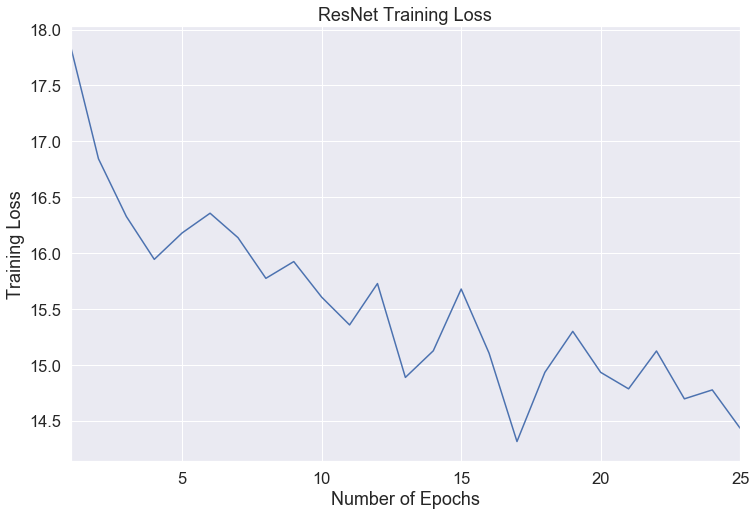

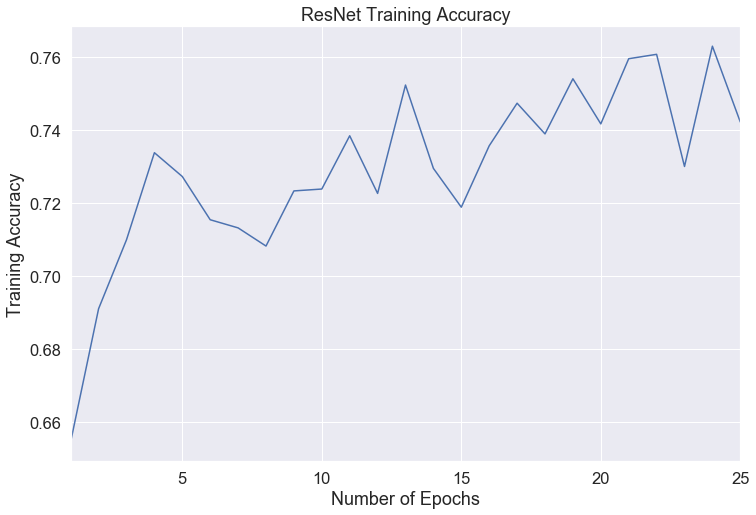

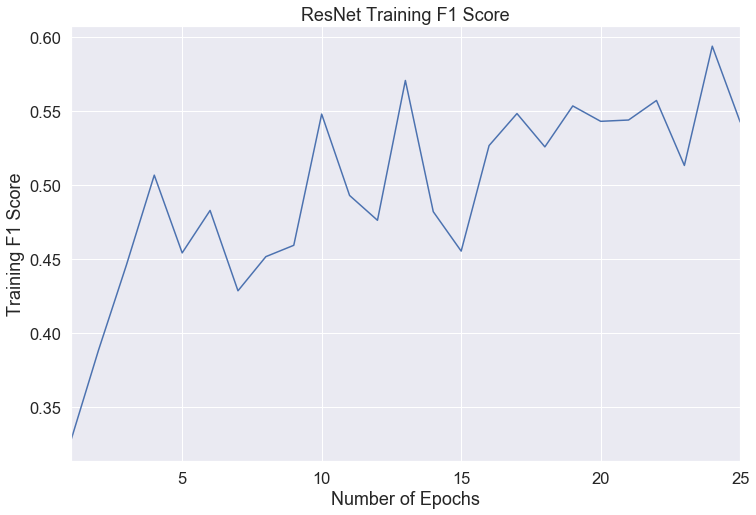

In [21]:
x = [i for i in range(1, num_epochs+1)]

plt.figure(figsize=(12, 8))
plt.plot(x, loss_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.title('ResNet Training Loss')
plt.xlim([1, num_epochs])
plt.grid(True)

plt.figure(figsize=(12, 8))
plt.plot(x, acc_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Accuracy')
plt.title('ResNet Training Accuracy')
plt.xlim([1, num_epochs])
plt.grid(True)

plt.figure(figsize=(12, 8))
plt.plot(x, f1_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training F1 Score')
plt.title('ResNet Training F1 Score')
plt.xlim([1, num_epochs])
plt.grid(True)

## Test Model on Testing Set

In [22]:
model.eval()    # test model

for samples, target in test_loader:
    opt.zero_grad()
    output = model(samples)
    loss = criterion(output, target.squeeze(1).long())

    _, pred = torch.max(output, 1)
    
acc = torch.sum(pred == target.squeeze(1).long()).float() / len(target)
f1 = f1_score(target, pred)
conf_matrix = confusion_matrix(target.numpy(), pred.numpy(), labels=[0, 1])

print('\nTest Accuracy: {:0.4f}'.format(acc))
print('\nF1 Score: {:0.4f}'.format(f1))
print('Confusion Matrix:')
display(pd.DataFrame(conf_matrix))
print('\n\n')


Test Accuracy: 0.7539

F1 Score: 0.6357
Confusion Matrix:


,0,1
0,103,30
1,17,41
